# Set Environment

In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_gbq

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
# authenticate
auth.authenticate_user()

In [3]:
# Set up environment variables
project_id = 'model-wave-394405'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'

# Feature Selection

## Select stroke patients

In [4]:
select_stroke_query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE icd_code LIKE 'I61%' OR icd_code LIKE 'I63%';
"""
stroke_df = run_query(select_stroke_query)
stroke_subject_ids = stroke_df['subject_id'].unique().tolist()
stroke_hadm_ids = stroke_df['hadm_id'].unique().tolist()

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


## Demographics

### admittime, dischtime, deathtime, insurance, martial status, race

In [5]:
select_demographics_query_in_admission = f"""
SELECT subject_id, hadm_id, admittime, dischtime, deathtime, insurance, marital_status, race
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))})
AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))});
"""
demographics_df = run_query(select_demographics_query_in_admission)
demographics_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND
...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE


### gender, age

In [6]:

select_gender_and_age_query = f"""
SELECT subject_id,gender, anchor_age
FROM `physionet-data.mimiciv_hosp.patients`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))});
"""
gender_and_df = run_query(select_gender_and_age_query)
demographics_df = demographics_df.merge(gender_and_df, on=['subject_id'], how='inner')
demographics_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52
...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62


### weight

In [7]:
# 226512 Admission weight
select_weight_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as weight
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 226512 AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
weight_df = run_query(select_weight_query)
weight_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,weight
0,17804022,24697053,59.1
1,17605210,22849785,88.5
2,16026359,23809913,73.5
3,10355856,29999625,125.0
4,10909143,29830422,47.1
...,...,...,...
2412,17623453,25231015,73.0
2413,11586759,29076264,58.0
2414,16752897,20984674,60.0
2415,11015907,26820180,66.0


In [8]:
demographics_df = demographics_df.merge(weight_df, on=['subject_id','hadm_id'], how='left')
demographics_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0


## Vital signs

In [9]:
# 220045  heart rate
# 220210  Respiratory Rate
# 220050  Arterial Blood Pressure systolic
# 220051  Arterial Blood Pressure diastolic
# 220052  Arterial Blood Pressure mean
# 228232  PAR-Oxygen saturation

select_vital_signs_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE itemid IN (220045, 220210, 220050, 220051, 220052, 228232);
"""
vital_signs_query = run_query(select_vital_signs_query)
vital_signs_query


<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN
1,228232,PAR-Oxygen saturation,PAR-Oxygen saturation,chartevents,Routine Vital Signs,None,Text,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
4,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
5,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


### Heart Rate

In [10]:
select_hr_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as hr_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220045 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
hr_df = run_query(select_hr_query)
hr_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,hr_value
0,19767462,23569057,89.935484
1,17445690,28363980,72.457143
2,10304606,25532105,72.505459
3,19309506,28828989,88.140468
4,10864650,25070229,78.857143
...,...,...,...
2415,11199155,24570181,62.769231
2416,19980800,29736429,66.941176
2417,16392764,24922008,88.611111
2418,14421640,20326144,58.142857


In [11]:
demographics_vitial_signs_df = demographics_df.merge(hr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347


### Respiratory Rate

In [12]:
select_rr_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as rr_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220210 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
rr_df = run_query(select_rr_query)
rr_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,rr_value
0,17608878,22135112,22.268713
1,10024982,25154057,21.084428
2,10049041,23314477,15.821138
3,18791883,23894507,14.664557
4,19404265,26466590,24.767347
...,...,...,...
2414,13109578,26647966,21.166667
2415,10200310,25099208,17.264706
2416,13447499,28357607,21.642857
2417,11866506,29114539,15.260870


In [13]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(rr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959


### SPO2

In [14]:
select_SPO2_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as SPO2_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 228232 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
SPO2_df = run_query(select_SPO2_query)
SPO2_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,SPO2_value
0,15456129,23276396,2.000000
1,17032851,26219826,1.444444
2,18532889,26946329,1.166667
3,14643554,28137438,0.000000
4,13762552,27329464,1.000000
...,...,...,...
177,15693180,25744835,2.000000
178,19874175,24919300,1.250000
179,12625353,24227229,1.000000
180,13419296,27921658,2.000000


In [15]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(SPO2_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN


### Arterial Blood Pressure systolic

In [16]:
select_BPS_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPS_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220050 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPS_df = run_query(select_BPS_query)
BPS_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,BPS_value
0,10057482,25416257,120.893120
1,10355856,29999625,126.195652
2,13929840,25398850,122.000000
3,16358152,28359716,111.014085
4,16359089,23982922,166.686441
...,...,...,...
751,19088714,21071082,136.428571
752,13021846,21215121,109.809524
753,16835786,29341398,142.615385
754,11731531,24078707,151.000000


In [17]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPS_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN


### Arterial Blood Pressure diastolic

In [18]:
select_BPD_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPD_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220051 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPD_df = run_query(select_BPD_query)
BPD_df



<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,BPD_value
0,18208117,24530240,41.431438
1,19756905,27136267,64.288660
2,13467066,27794492,49.053165
3,17395063,23092156,60.836364
4,16963541,25415666,64.118644
...,...,...,...
751,18461335,28002627,74.909091
752,15568901,24358333,55.535714
753,18179092,22786251,59.571429
754,14417339,28899895,59.600000


In [19]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPD_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN


### Arterial Blood Pressure Mean

In [20]:
select_BPM_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPM_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220052 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPM_df = run_query(select_BPM_query)
BPM_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,BPM_value
0,16825279,23283649,71.240964
1,18761820,21769335,81.875912
2,10215159,24039782,81.611111
3,15857793,21064907,76.312684
4,18843829,25308148,91.579710
...,...,...,...
754,17843659,23029559,74.750000
755,13419296,27921658,89.518519
756,17178836,24522653,76.000000
757,13425764,22805151,86.500000


In [21]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPM_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN


## Laboratory results

In [22]:
# Anion Gap 227073
# Chloride (serum)	220602

select_laboratory_results_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%chloride%'
"""
laboratory_results_query = run_query(select_laboratory_results_query)
laboratory_results_query

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220602,Chloride (serum),Chloride (serum),chartevents,Labs,None,Numeric,NaN,NaN
1,226536,Chloride (whole blood),Chloride (whole blood),chartevents,Labs,None,Numeric,NaN,NaN
2,228385,Chloride (serum) (soft),Chloride (serum) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
3,228386,Chloride (whole blood) (soft),Chloride (whole blood) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
4,225166,Potassium Chloride,Potassium Chloride - KCL,inputevents,Medications,mEq,Solution,NaN,NaN
5,227520,Methadone Hydrochloride,Methadone Hydrochloride,inputevents,Medications,mg,Solution,NaN,NaN
6,229618,Calcium Chloride,Calcium Chloride,inputevents,Medications,mg,Solution,NaN,NaN
7,220367,Chloride (ingr),Cl (ingr),ingredientevents,Ingredients - general (Not In Use),mg,Ingredient,NaN,NaN


### Anion Gap

In [23]:
select_AG_query = f"""
SELECT subject_id, hadm_id, AVG(AG_value) AS AG_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS AG_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 227073
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
AG_df = run_query(select_AG_query)
AG_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,AG_value
0,14115052,25085304,13.666667
1,18821656,23496573,15.000000
2,19962418,25331514,14.054054
3,18119847,23243341,19.250000
4,18341422,29388395,11.250000
...,...,...,...
2277,11219612,25403739,15.000000
2278,16994918,21364325,14.000000
2279,14083248,28995548,12.000000
2280,15809638,26583061,12.000000


In [24]:
demo_vs_lab_df = demographics_vitial_signs_df.merge(AG_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75


### Chloride (serum)

In [25]:
select_chloride_query = f"""
SELECT subject_id, hadm_id, AVG(chloride_value) AS chloride_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS chloride_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220602
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
chloride_df = run_query(select_chloride_query)
chloride_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,chloride_value
0,19297868,25776572,91.750000
1,19016548,27422748,105.428571
2,16893981,27463699,104.000000
3,19171736,23671920,106.000000
4,10723263,24568459,101.083333
...,...,...,...
2277,16895456,25620132,105.000000
2278,18003764,27896838,106.000000
2279,15556698,26628429,106.000000
2280,19949052,28096518,104.000000


In [26]:
demo_vs_lab_df = demo_vs_lab_df.merge(chloride_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75


### Bicarbonate

In [27]:
# Red Blood Cells counts 51279
# White Blood Cells 51301
# Bicarbonate 50882

select_bicarbonate_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS bicarbonate_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 50882 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
bicarbonate_df = run_query(select_bicarbonate_query)
bicarbonate_df


<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,bicarbonate_value
0,10031358,29498981,23.000000
1,10059406,23005038,26.382353
2,10063856,29364646,28.333333
3,10067389,23577021,14.709677
4,10088966,27318566,28.318182
...,...,...,...
3823,12326925,23182129,32.000000
3824,11093362,28264071,27.000000
3825,19503769,20261940,27.000000
3826,12873584,23469748,25.000000


In [28]:
demo_vs_lab_df = demo_vs_lab_df.merge(bicarbonate_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667


### Red Blood Cells counts

In [29]:

select_RBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS RBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
RBC_df = run_query(select_RBC_query)
RBC_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,RBC_value
0,10205881,20224452,3.580000
1,10438899,23438499,4.294286
2,10909916,26333407,2.977273
3,11001569,23809683,3.621667
4,11156214,23478063,2.797442
...,...,...,...
3817,13240991,24571907,3.760000
3818,13964956,24355098,4.630000
3819,15633577,24051380,3.840000
3820,12044530,28476340,3.700000


In [30]:
demo_vs_lab_df = demo_vs_lab_df.merge(RBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723


### White Blood Cells counts

In [31]:
select_WBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS WBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
WBC_df = run_query(select_WBC_query)
WBC_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,WBC_value
0,10387412,28763199,3.620000
1,10723263,24568459,2.980667
2,10809663,27669905,2.599375
3,10996857,27194160,3.225769
4,12021215,24210605,3.655455
...,...,...,...
3817,13981659,26479009,4.640000
3818,11085838,26061438,3.230000
3819,16682729,28332408,4.920000
3820,19561931,27078519,4.390000


In [32]:
demo_vs_lab_df = demo_vs_lab_df.merge(WBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723


## assessment scale scores

In [33]:
# 220739 GCS - Eye Opening
# 223900 GCS - Verbal Response
# 223901 GCS - Motor Response
select_assessment_scores_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%gcs%'
"""
assessment_scores_query = run_query(select_assessment_scores_query)
assessment_scores_query

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220739,GCS - Eye Opening,Eye Opening,chartevents,Neurological,None,Text,NaN,NaN
1,223900,GCS - Verbal Response,Verbal Response,chartevents,Neurological,None,Text,NaN,NaN
2,223901,GCS - Motor Response,Motor Response,chartevents,Neurological,None,Text,NaN,NaN
3,226756,GCSEyeApacheIIValue,GCSEyeApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
4,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
5,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
6,228112,GCSVerbalApacheIIValue (intubated),GCSVerbalApacheIIValue (intubated),chartevents,Scores - APACHE II,None,Text,NaN,NaN
7,226755,GcsApacheIIScore,GcsApacheIIScore,chartevents,Scores - APACHE II,None,Numeric,NaN,NaN
8,227011,GCSEye_ApacheIV,GCSEye_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN
9,227012,GCSMotor_ApacheIV,GCSMotor_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN


In [34]:
select_GCS_eye_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_eye_opening_score) AS GCS_eye_opening_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_eye_opening_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220739
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_eye_df = run_query(select_GCS_eye_query)
GCS_eye_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,GCS_eye_opening_score
0,13352372,28752421,3.213592
1,16108561,20799110,2.782609
2,11210655,23711612,3.166667
3,19924524,20972456,3.076923
4,18172623,24092412,3.400000
...,...,...,...
2411,19011545,25848363,3.538462
2412,14654370,28651805,4.000000
2413,18242742,25351610,1.000000
2414,19251108,27747739,3.200000


In [35]:
select_GCS_verbal_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_verbal_score) AS GCS_verbal_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_verbal_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223900
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_verbal_df = run_query(select_GCS_verbal_query)
GCS_verbal_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,GCS_verbal_score
0,11379140,20053836,2.107143
1,14452125,25304359,4.244681
2,12842941,23480053,2.000000
3,12670557,26462705,4.250000
4,16527226,21501769,5.000000
...,...,...,...
2411,15533907,28292401,1.000000
2412,17851944,24510690,1.000000
2413,10838163,25562604,1.000000
2414,18759451,22541070,4.500000


In [36]:
select_GCS_Motor_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_Motor_score) AS GCS_Motor_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_Motor_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223901
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_Motor_df = run_query(select_GCS_Motor_query)
GCS_Motor_df

<ipython-input-3-2784181079c2>:7: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


,subject_id,hadm_id,GCS_Motor_score
0,15437180,24344831,4.000000
1,15693180,25744835,4.368421
2,16536690,20770305,6.000000
3,19273062,26711753,6.000000
4,13214523,23133305,5.500000
...,...,...,...
2411,16428221,24414610,6.000000
2412,11160706,24475188,6.000000
2413,17293846,22176562,1.000000
2414,15418295,27787772,4.714286


In [37]:
GCS_score = GCS_eye_df.merge(GCS_verbal_df, on=['subject_id', 'hadm_id']).merge(GCS_Motor_df, on=['subject_id', 'hadm_id'])
GCS_score['GCS_score'] = GCS_score[['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score']].sum(axis=1)
GCS_score = GCS_score.drop(columns=['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score'])
GCS_score

,subject_id,hadm_id,GCS_score
0,13352372,28752421,7.834951
1,16108561,20799110,12.782609
2,11210655,23711612,12.611111
3,19924524,20972456,14.076923
4,18172623,24092412,14.400000
...,...,...,...
2411,19011545,25848363,14.307692
2412,14654370,28651805,12.615385
2413,18242742,25351610,3.000000
2414,19251108,27747739,11.600000


## Merged all features

In [38]:
merged_df = demo_vs_lab_df.merge(GCS_score, on=['subject_id','hadm_id'], how='left')
merged_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value,GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000,3.375000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250,2.926250,6.833333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500,14.400000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714,3.000000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723,7.826087


# Pre-processing

In [39]:
na_columns = merged_df.isna().sum()
na_columns_with_na = na_columns[na_columns > 0]
print(na_columns_with_na)


deathtime            3455
marital_status        426
weight               1549
hr_value             1546
rr_value             1547
SPO2_value           3784
BPS_value            3210
BPD_value            3210
BPM_value            3207
AG_value             1684
chloride_value       1684
bicarbonate_value     138
RBC_value             144
WBC_value             144
GCS_score            1550
dtype: int64


## Convert Death time to 1 and 0

In [40]:
merged_df.loc[merged_df['deathtime'].notna(),'dod'] = int(1)
merged_df.loc[merged_df['deathtime'].isnull(),'dod'] = int(0)
merged_df['dod'] = merged_df['dod'].astype(int)
merged_df.drop(columns=['deathtime'], inplace=True)
merged_df.shape

(3966, 23)

## Handle missing values

In [41]:
def create_check_test_columns(df, columns):

    for col in columns:
        # Create a new test column, True indicates the value is present, False indicates missing
        df[f'test_{col}'] = df[col].notna()
    return df

def fill_na_with_zero(df, columns):
  for col in columns:
        # Fill missing values with 0
        df[col] = df[col].fillna(0)
  return df

# List of columns to be processed
columns_to_handle = ['AG_value', 'chloride_value', 'bicarbonate_value', 'RBC_value', 'WBC_value',
                     'marital_status', 'weight', 'hr_value', 'rr_value', 'SPO2_value',
                     'BPS_value', 'BPD_value', 'BPM_value','GCS_score']

# Call the function to handle missing values
merged_df = create_check_test_columns(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,None,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,NaN,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


In [43]:
# print the column of the final dataset
merged_df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'insurance',
       'marital_status', 'race', 'gender', 'anchor_age', 'weight', 'hr_value',
       'rr_value', 'SPO2_value', 'BPS_value', 'BPD_value', 'BPM_value',
       'AG_value', 'chloride_value', 'bicarbonate_value', 'RBC_value',
       'WBC_value', 'GCS_score', 'dod', 'test_AG_value', 'test_chloride_value',
       'test_bicarbonate_value', 'test_RBC_value', 'test_WBC_value',
       'test_marital_status', 'test_weight', 'test_hr_value', 'test_rr_value',
       'test_SPO2_value', 'test_BPS_value', 'test_BPD_value', 'test_BPM_value',
       'test_GCS_score'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8929
Precision: 0.6438
Recall: 0.4434
F1 Score: 0.5251
AUC Score: 0.8980

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       688
           1       0.64      0.44      0.53       106

    accuracy                           0.89       794
   macro avg       0.78      0.70      0.73       794
weighted avg       0.88      0.89      0.88       794



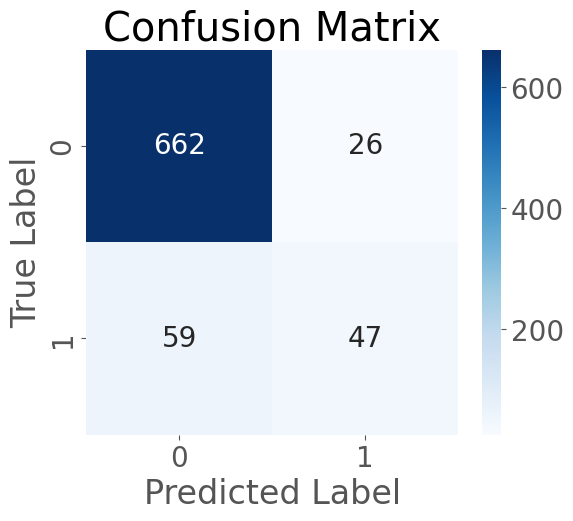

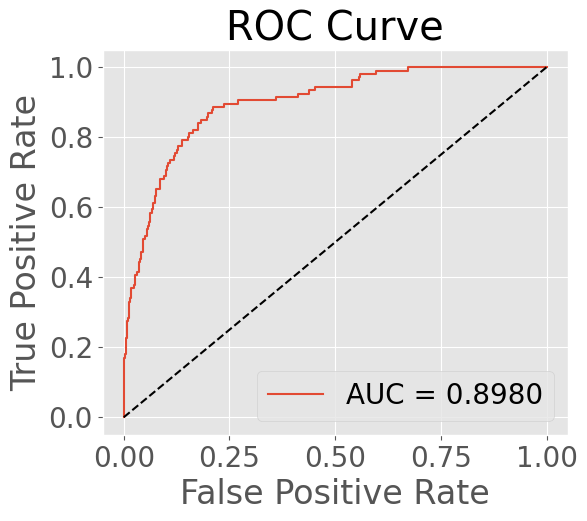

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' already exists

# Drop unnecessary columns
data = merged_df.drop(columns=['subject_id', 'hadm_id', 'admittime', 'dischtime'])

# Check and handle missing values (drop rows with missing values)
data = data.dropna()

# Separate features and target variable
X = data.drop(columns=['dod'])
y = data['dod']

# Identify categorical columns (adjust based on your dataset)
categorical_columns = ['insurance', 'marital_status', 'race', 'gender']

# One-Hot Encode categorical variables
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC Score: {auc:.4f}')

# Print classification report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, zero_division=0))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
